In [26]:
import numpy as np
import pandas as pd
import numpy as np
import time
import os
import logging
import implicit
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
import itertools
import sys
import numpy
from collections import defaultdict

Train ratings

In [69]:
ml=pd.read_csv('ratings.csv')

In [70]:
df1 = ml[['userId', 'movieId', 'rating']]

In [71]:
datainfo(df1)

Number of users: 671
Number of movies: 9066
Sparsity: 1.644%


In [72]:
mti, itm, uti, itu=mapping(df1)

In [73]:
train, test = train_test_split(df1, test_size=0.15)

In [74]:
train_unr= train[['userId', 'movieId']]
test_unr=test[['userId', 'movieId']]

In [75]:
df1_likes_train=sparse_create(train_unr, uti, mti)
df1_likes_test=sparse_create(test_unr, uti, mti)

In [76]:
m50=model_create(50, df1_likes_train)

In [77]:
predict_for_user_top_n(m50, test, 1, 10, mti, itm)

[[590, 1.0045424749901464],
 [150, 1.0003054100023643],
 [457, 0.94442417344729523],
 [592, 0.89797411517029957],
 [296, 0.88495765871959942],
 [593, 0.87990962960546104],
 [356, 0.87779515110940565],
 [588, 0.87772027869250757],
 [480, 0.87673970631822085],
 [380, 0.83825472801022982]]

Train ua.base

In [2]:
fg=pd.read_csv('ua.base', sep='\t', names=['userId','movieId','rating','4'])
fgt=pd.read_csv('ua.test', sep='\t', names=['userId','movieId','rating','4'])

In [3]:
df2 = fg[['userId', 'movieId', 'rating']]
df2t = fgt[['userId', 'movieId', 'rating']]

In [20]:
datainfo(df2)

Number of users: 943
Number of movies: 1680
Sparsity: 5.717%


In [21]:
mti, itm, uti, itu=mapping(pd.concat([df2, df2t]))

In [22]:
df2_likes_train=sparse_create(df2, uti, mti)
df2е_likes_test=sparse_create(df2t, uti, mti)

In [207]:
m50=model_create(50, df2_likes_train)

In [23]:
m5=model_create(5, df2_likes_train)
m10=model_create(10, df2_likes_train)
m20=model_create(20, df2_likes_train)
m30=model_create(30, df2_likes_train)
m50=model_create(50, df2_likes_train)
m100=model_create(100, df2_likes_train)

In [27]:
aucs=[]
aucs.append(auc(m5, df2t, df2))
aucs.append(auc(m10, df2t, df2))
aucs.append(auc(m20, df2t, df2))
aucs.append(auc(m30, df2t, df2))
aucs.append(auc(m50, df2t, df2))
aucs.append(auc(m100, df2t, df2))

Current AUC mean (900 samples): 0.92374
Current AUC mean (900 samples): 0.93233
Current AUC mean (900 samples): 0.92635
Current AUC mean (900 samples): 0.91701
Current AUC mean (900 samples): 0.89501
Current AUC mean (900 samples): 0.84200


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [30]:
aucs

[0.92360337727535047,
 0.93221554725417932,
 0.92635242836079357,
 0.91698546452559015,
 0.89524895547329864,
 0.84208255613885707]

In [31]:
aucs1=[0.92061229244928111,
 0.92649796712607191,
 0.916325895170786,
 0.90238331530429772,
 0.87456191479984624,
 0.81609550841763046]

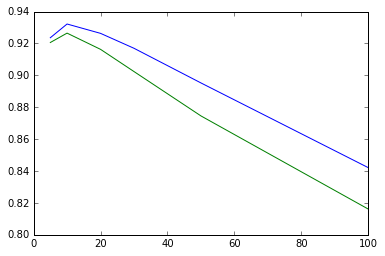

In [32]:
plt.plot([5, 10, 20, 30, 50, 100], aucs)
plt.plot([5, 10, 20, 30, 50, 100], aucs1)

In [24]:
predict_for_user_top_n(m50, df2t, 19, 10, mti, itm)

[[50, 0.80186735935683751],
 [181, 0.71839248951077883],
 [1, 0.65670836904639096],
 [174, 0.57257258352204365],
 [82, 0.51450601158266562],
 [210, 0.49257613128265537],
 [121, 0.47921325868850184],
 [151, 0.46331422732617977],
 [71, 0.45767865175975586],
 [143, 0.45498391345982858]]

In [129]:
predict_for_user(m50, 0)

9066

Функции

In [5]:
def datainfo(data):
    n_users = data.userId.unique().shape[0]
    n_items = data.movieId.unique().shape[0]

    print('Number of users: {}'.format(n_users))
    print('Number of movies: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(float(data.shape[0]) / float(n_users*n_items) * 100))

In [6]:
def mapping(df):
    mid_to_idx = {}
    idx_to_mid = {}
    for (idx, mid) in enumerate(df.movieId.unique().tolist()):
        mid_to_idx[mid] = idx
        idx_to_mid[idx] = mid
    
    uid_to_idx = {}
    idx_to_uid = {}
    for (idx, uid) in enumerate(df.userId.unique().tolist()):
        uid_to_idx[uid] = idx
        idx_to_uid[idx] = uid
        
    return mid_to_idx, idx_to_mid, uid_to_idx, idx_to_uid

In [7]:
def _map_ids(row, mapper):
    return mapper[row]

In [8]:
def sparse_create(df, uid_to_idx, mid_to_idx):
    I = df.userId.apply(_map_ids, args=[uid_to_idx]).as_matrix()
    J = df.movieId.apply(_map_ids, args=[mid_to_idx]).as_matrix()
    V = np.ones(I.shape[0])
    likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
    likes = likes.tocsr()
    return likes

In [9]:
def model_create(n, sdata):
    model = implicit.als.AlternatingLeastSquares(factors=n)
    model.fit(sdata.T)
    return model

In [10]:
def _data_convert(data):
    mlp=data.pivot(index='userId', columns='movieId', values='rating')
    mlp=mlp.replace([0.5, 1.0, 1.5, 2.0, 2.5, 3.0,3.5, 4.0, 4.5, 5.0], 
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
    mlp=mlp.fillna(0)
    return mlp* mlpn.columns.values

In [11]:
def _liked_convert(liked, mti):
    ld=[]
    for i in liked:
        ld.append(mti[i])
        
    return ld

In [12]:
def predict_for_user_top_n(models, ratings, k, n, mti, itm):
    #scores=models.item_factors.dot(models.user_factors[k])
    scores=models.user_factors[k].dot(models.item_factors.T)
    #mlpn=_data_convert(ratings)
    mr=ratings[ratings.userId==k+1]['movieId']
    liked=list(set(mr))[0:len(set(mr))]
    ld=_liked_convert(liked, mti)
    count=n+len(ld)
    if count<len(scores):
        ids = np.argpartition(scores, -count)[-count:]
        best = sorted(zip(ids,scores[ids]), key=lambda x:-x[1])
    else:
        best = sorted(enumerate(scores), key=lambda x:-x[1])
    return list(itertools.islice(([itm[rec[0]], rec[1]] for rec in best if rec[0] not in ld), n))

In [13]:
from sklearn.metrics import mean_squared_error
def calculate_mse(model, ratings, user_index=None):
    preds = predict_for_customers(model)
    if user_index:
        return mean_squared_error(ratings[user_index, :].toarray().ravel(),
                                  preds[user_index, :].ravel())
    
    return mean_squared_error(ratings.toarray().ravel(),
                              preds.ravel())

In [14]:
def precision_at_k(model, ratings, k=5, user_index=None):
    if not user_index:
        user_index = range(ratings.shape[0])
    ratings = ratings.tocsr()
    precisions = []
    recalls=[]
    # Note: line below may become infeasible for large datasets.
    predictions = predict_for_customers(model)
    for user in user_index:
        # In case of large dataset, compute predictions row-by-row like below
        # predictions = np.array([model.predict(row, i) for i in xrange(ratings.shape[1])])
        top_k = np.argsort(-predictions[user, :])[:k]
        #print(top_k)
        labels = ratings.getrow(user).indices
        precision = float(len(set(top_k) & set(labels))) / float(k)
        precisions.append(precision)
        if len(labels) >0:
            recall = float(len(set(top_k) & set(labels)))/float(len(labels))
            recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)   

In [15]:
    def predict_for_customers(model):
        """Recommend products for all customers"""
        return model.user_factors.dot(model.item_factors.T)
        #return self.user_vectors.dot(self.item_vectors.T)

In [16]:
def predict_for_user(model, n):
    return model.item_factors.dot(model.user_factors[n])

In [17]:
    def _data_to_dict(data):
        data_dict = defaultdict(list)
        items = set()
        for user in data.iterrows():
            data_dict[uti[int(user[1][0])]].append(mti[int(user[1][1])])
            items.add(mti[int(user[1][1])])
        return data_dict, set(data_dict.keys()), items

In [18]:
import sys
import numpy

In [19]:
    def auc(model, test_data, train_data):
        """
          Computes the Area Under Curve (AUC) on `test_data`.
          `test_data` is an array of (user_index, item_index) tuples.
          During this computation we ignore users and items
          that didn't appear in the training data, to allow
          for non-overlapping training and testing sets.
        """
        test_dict, test_users, test_items = _data_to_dict(test_data)
        _train_dict, _train_users, _train_items = _data_to_dict(train_data)
        auc_values = []
        z = 0
        for user in test_dict.keys():
            if user in _train_users:
                auc_for_user = 0.0
                n = 0
                predictions = predict_for_user(model, user)
                for pos_item in test_dict[user]:
                    if pos_item in _train_items:
                        for neg_item in _train_items:
                            if neg_item not in test_dict[user] and neg_item not in _train_dict[user]:
                                n += 1
                                if predictions[pos_item] > predictions[neg_item]:
                                    auc_for_user += 1
                if n > 0:
                    auc_for_user /= n
                    auc_values.append(auc_for_user)
                z += 1
                if z % 100 == 0 and len(auc_values) > 0:
                    sys.stderr.write("\rCurrent AUC mean (%s samples): %0.5f" % (str(z), numpy.mean(auc_values)))
                    sys.stderr.flush()
        sys.stderr.write("\n")
        sys.stderr.flush()
        return numpy.mean(auc_values)

In [221]:
auc(m50, df2t, df2)

Current AUC mean (900 samples): 0.89592


0.89607961176412776

In [65]:
    mr=df2[df2.userId==1]['movieId']
    liked=list(set(mr))[1:len(set(mr))]

In [45]:
ld=_liked_convert(liked, mti)

In [61]:
    k=0
    scores=m50.item_factors.dot(m50.user_factors[k])
    #mlpn=_data_convert(ratings)
    mr=df2[df2.userId==k+1]['movieId']
    liked=list(set(mr))[1:len(set(mr))]
    ld=_liked_convert(liked, mti)
    count=10+len(ld)
    if count<len(scores):
        ids = np.argpartition(scores, -count)[-count:]
        best = sorted(zip(ids,scores[ids]), key=lambda x:-x[1])
    else:
        best = sorted(enumerate(scores), key=lambda x:-x[1])
    list(itertools.islice((rec for rec in best if rec[0] not in ld), 10))

[(0, 1.2863270298572302),
 (558, 0.80442894470225845),
 (744, 0.79908298476487249),
 (375, 0.79238873227107498),
 (430, 0.74880115115504786),
 (282, 0.74748697008040688),
 (446, 0.67590303759131498),
 (270, 0.67422545820924207),
 (444, 0.67224585810618009),
 (486, 0.6681818361256523)]